In [1]:
# Setting up env variables for cleaner command line commands.
import os

%env KEY=tlt_encode
%env NUM_GPUS=1
%env USER_EXPERIMENT_DIR=/workspace/tlt-experiments/detectnet_v2
%env DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/data

# Set this path if you don't run the notebook from the samples directory.
# %env NOTEBOOK_ROOT=~/tlt-samples/detectnet_v2

# Please define this local project directory that needs to be mapped to the TLT docker session.
# The dataset expected to be present in $LOCAL_PROJECT_DIR/data, while the results for the steps
# in this notebook will be stored at $LOCAL_PROJECT_DIR/detectnet_v2
# !PLEASE MAKE SURE TO UPDATE THIS PATH!.

os.environ["LOCAL_PROJECT_DIR"] = "/home/ucit/UcitData/"

os.environ["LOCAL_DATA_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "data"
)
os.environ["LOCAL_EXPERIMENT_DIR"] = os.path.join(
    os.getenv("LOCAL_PROJECT_DIR", os.getcwd()),
    "detectnet_v2"
)

# The sample spec files are present in the same path as the downloaded samples.
os.environ["LOCAL_SPECS_DIR"] = os.path.join(
    os.getenv("NOTEBOOK_ROOT", os.getcwd()),
    "specs"
)
%env SPECS_DIR=/workspace/tlt-experiments/detectnet_v2/specs

# Showing list of specification files.
!ls -rlt $LOCAL_SPECS_DIR

env: KEY=tlt_encode
env: NUM_GPUS=1
env: USER_EXPERIMENT_DIR=/workspace/tlt-experiments/detectnet_v2
env: DATA_DOWNLOAD_DIR=/workspace/tlt-experiments/data
env: SPECS_DIR=/workspace/tlt-experiments/detectnet_v2/specs
total 128
-rw-rw-r-- 1 ucit ucit  310 2月  25 21:15 detectnet_v2_tfrecords_kitti_trainval.txt
-rw-rw-r-- 1 ucit ucit 5675 2月  25 21:15 detectnet_v2_retrain_resnet18_kitti_qat.txt
-rw-rw-r-- 1 ucit ucit 2406 2月  25 21:15 detectnet_v2_inference_kitti_tlt.txt
-rw-rw-r-- 1 ucit ucit 2436 2月  25 21:15 detectnet_v2_inference_kitti_etlt.txt
-rw-rw-r-- 1 ucit ucit 2445 2月  25 21:15 detectnet_v2_inference_kitti_etlt_qat.txt
drwxr-xr-x 3 root root 4096 4月  14 13:23 tfrecords
-rw-rw-r-- 1 ucit ucit  310 4月  19 18:12 detectnet_v2_tfrecords_kitti_trainval_xuekitti.txt
-rw-rw-r-- 1 ucit ucit 5642 4月  20 10:41 detectnet_v2_train_resnet18_xuekitti.txt
-rw-rw-r-- 1 ucit ucit 5635 4月  20 11:18 detectnet_v2_retrain_resnet18_xuekitti.txt
-rw-rw-r-- 1 ucit ucit  310 4月  20 18:26 detectnet_v2_tf

In [2]:
# Mapping up the local directories to the TLT docker.
import json
mounts_file = os.path.expanduser("~/.tlt_mounts.json")

# Define the dictionary with the mapped drives
drive_map = {
    "Mounts": [
        # Mapping the data directory
        {
            "source": os.environ["LOCAL_PROJECT_DIR"],
            "destination": "/workspace/tlt-experiments"
        },
        # Mapping the specs directory.
        {
            "source": os.environ["LOCAL_SPECS_DIR"],
            "destination": os.environ["SPECS_DIR"]
        },
    ]
}

# Writing the mounts file.
with open(mounts_file, "w") as mfile:
    json.dump(drive_map, mfile, indent=4)

In [3]:
# View the versions of the TLT launcher
!tlt info

Configuration of the TLT Instance
dockers: ['nvcr.io/nvidia/tlt-streamanalytics', 'nvcr.io/nvidia/tlt-pytorch']
format_version: 1.0
tlt_version: 3.0
published_date: 02/02/2021


In [4]:
# Create the target destination to download the model.
#!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_resnet18/

# for trafficCamera folder
!mkdir -p $LOCAL_EXPERIMENT_DIR/pretrained_trafficcamnet/

In [5]:
# Installing NGC CLI on the local machine.
## Download and install
%env CLI=ngccli_reg_linux.zip
!mkdir -p $LOCAL_PROJECT_DIR/ngccli

# Remove any previously existing CLI installations
!rm -rf $LOCAL_PROJECT_DIR/ngccli/*
!wget "https://ngc.nvidia.com/downloads/$CLI" -P $LOCAL_PROJECT_DIR/ngccli
!unzip -u "$LOCAL_PROJECT_DIR/ngccli/$CLI" -d $LOCAL_PROJECT_DIR/ngccli/
!rm $LOCAL_PROJECT_DIR/ngccli/*.zip 
os.environ["PATH"]="{}/ngccli:{}".format(os.getenv("LOCAL_PROJECT_DIR", ""), os.getenv("PATH", ""))

env: CLI=ngccli_reg_linux.zip
--2021-04-30 15:01:06--  https://ngc.nvidia.com/downloads/ngccli_reg_linux.zip
Resolving ngc.nvidia.com (ngc.nvidia.com)... 13.33.211.85, 13.33.211.16, 13.33.211.110, ...
Connecting to ngc.nvidia.com (ngc.nvidia.com)|13.33.211.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24976582 (24M) [application/zip]
Saving to: ‘/home/ucit/UcitData//ngccli/ngccli_reg_linux.zip’

ngccli_reg_linux.zi 100%[===================>]  23.82M  6.06MB/s    in 4.2s    

2021-04-30 15:01:10 (5.68 MB/s) - ‘/home/ucit/UcitData//ngccli/ngccli_reg_linux.zip’ saved [24976582/24976582]

Archive:  /home/ucit/UcitData//ngccli/ngccli_reg_linux.zip
  inflating: /home/ucit/UcitData//ngccli/ngc  
 extracting: /home/ucit/UcitData//ngccli/ngc.md5  


In [9]:
# Creating a new directory for the output tfrecords dump.
print("Begin to Generate KITTI format dataSets!!!!!")
!tlt detectnet_v2 inference -e $SPECS_DIR/detectnet_v2_inference_kitti_generate_tlt.txt \
                            -o $USER_EXPERIMENT_DIR/Outresults \
                            -i $DATA_DOWNLOAD_DIR/raw1 \
                            -k $KEY

Begin to Generate KITTI format dataSets!!!!!
2021-04-30 15:04:36,063 [WARNING] tlt.components.docker_handler.docker_handler: 
Docker will run the commands as root. If you would like to retain your
local host permissions, please add the "user":"UID:GID" in the
DockerOptions portion of the ~/.tlt_mounts.json file. You can obtain your
users UID and GID by using the "id -u" and "id -g" commands on the
terminal.
Using TensorFlow backend.
Using TensorFlow backend.
2021-04-30 07:04:40,578 [INFO] __main__: Overlain images will be saved in the output path.
2021-04-30 07:04:40,578 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer

2021-04-30 07:04:40,579 [WARNING] tensorflow: From /home/vpraveen/.cache/dazel/_dazel_vpraveen/216c8b41e526c3295d3b802489ac2034/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/inferencer/tlt_inferencer.py:83: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigPr

In [7]:
# Simple grid visualizer
#!pip3 install matplotlib==3.3.3
%matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
valid_image_ext = ['.jpg', '.png', '.jpeg', '.ppm']


def visualize_images(image_dir, num_cols=4, imgfrom=0,imgto=12):
    output_path = os.path.join(os.environ['LOCAL_EXPERIMENT_DIR'], image_dir)
    num_rows = int(ceil(float(imgfrom) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path) 
         if os.path.splitext(image)[1].lower() in valid_image_ext]
    for idx, img_path in enumerate(a[imgfrom:imgto]):
        print("idx:",idx)
        print("img_path:",img_path)
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        print("col_id:",col_id)
        print("row_id:",row_id)
        axarr[row_id, col_id].imshow(img) 

idx: 0
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/07791.jpg
col_id: 0
row_id: 0
idx: 1
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/03982.jpg
col_id: 1
row_id: 0
idx: 2
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/07829.jpg
col_id: 2
row_id: 0
idx: 3
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/07355.jpg
col_id: 3
row_id: 0
idx: 4
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/02351.jpg
col_id: 0
row_id: 1
idx: 5
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/01148.jpg
col_id: 1
row_id: 1
idx: 6
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/06332.jpg
col_id: 2
row_id: 1
idx: 7
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/09786.jpg
col_id: 3
row_id: 1
idx: 8
img_path: /home/ucit/UcitData/detectnet_v2/Outresults/images_annotated/02389.jpg
col_id: 0
row_id: 2
idx: 9
img_path: /home/ucit/

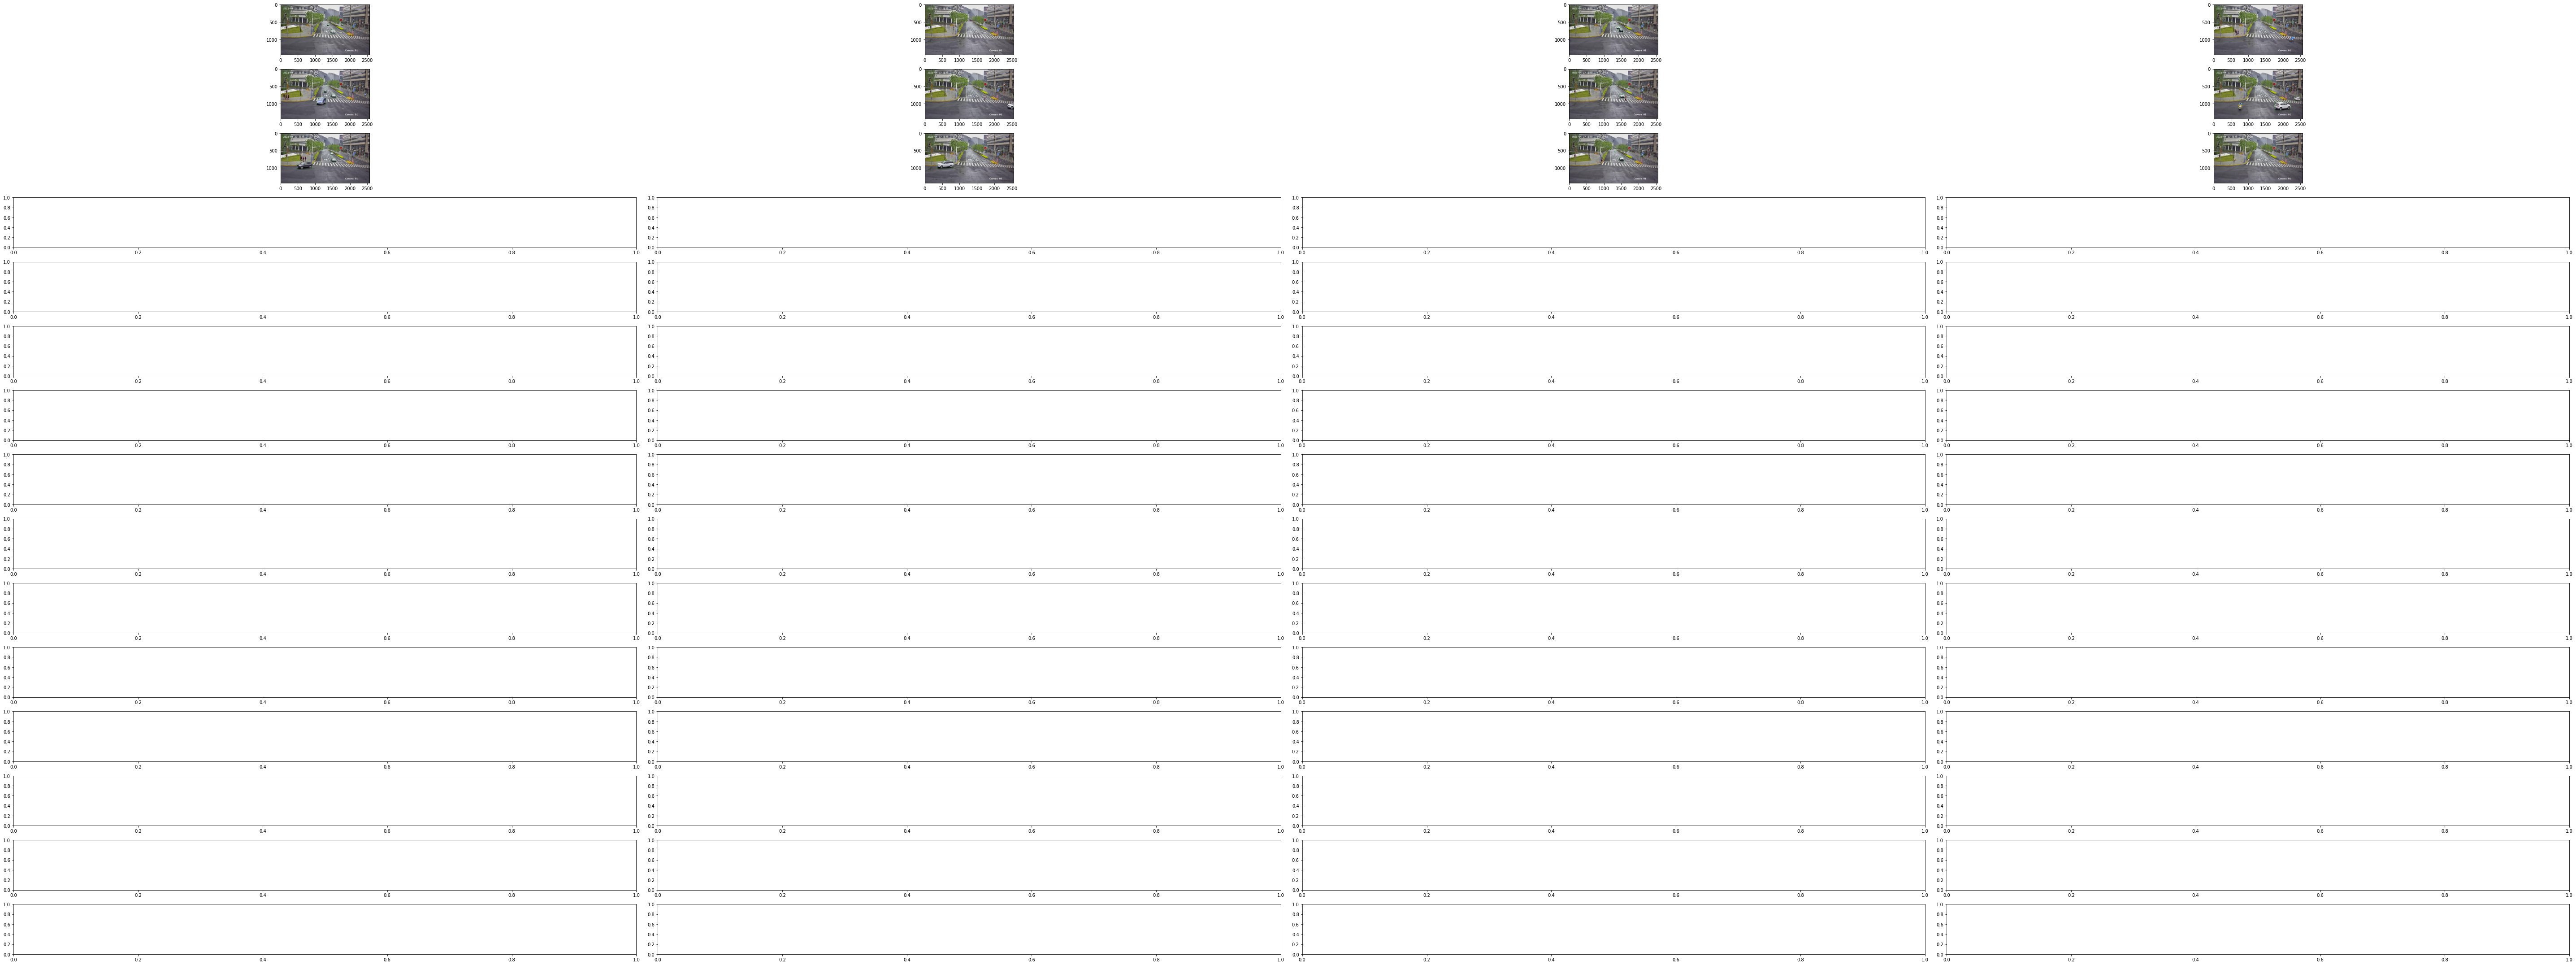

In [8]:
# Visualizing the first 12 images.
OUTPUT_PATH = 'Outresults/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
frompic = 58 # number of images to visualize.
topic = 70
visualize_images(OUTPUT_PATH, num_cols=COLS, imgfrom=frompic, imgto=topic)